#### SELF-RAG - SELF-EVALUATION

The traditional RAG (Retrieval-Augmented Generation) system is extended to create Self RAG. Wherein the language models are only enhanced to retrieve actual pieces of information from a knowledge base by RAG, Self RAG looks a bit beyond that. 
Self RAG demonstrates self-reflection mechanisms that allow the system to evaluate and also improve its generated outputs.

Flow of the self-rag : 
- **Retriever:** Retrieves relevant documents based on the input question.
- **Document Grader:** Grades the relevance of the retrieved documents
- **Web Search:** Searches online when the local document supply is insufficient.
- **Generator:** Generates a response based on the obtained information.
- **Generation Grader:** Grades the generated response for hallucinations and relevance.

The algorithm given by the research paper : SELF-RAG: LEARNING TO RETRIEVE, GENERATE, AND
CRITIQUE THROUGH SELF-REFLECTION (https://arxiv.org/pdf/2310.11511)

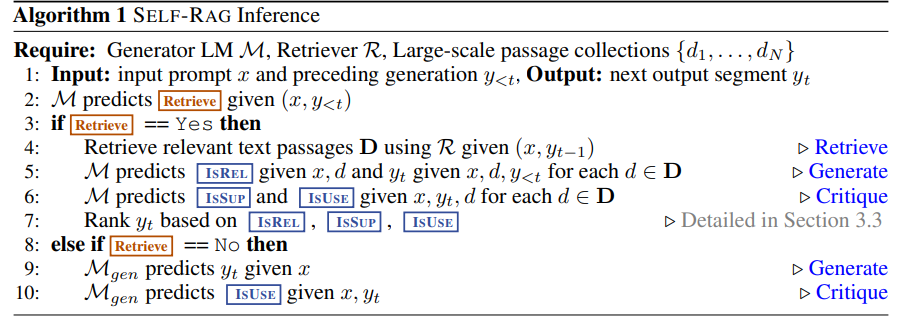

The graphical representation of this flow - By Langchain.
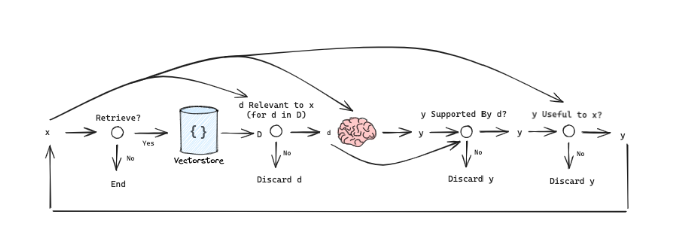

https://blog.langchain.dev/agentic-rag-with-langgraph/
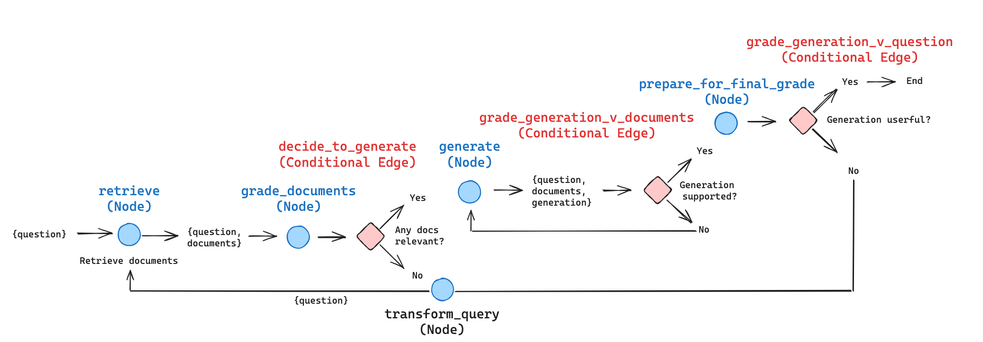

In [145]:
# Importing necessary libraries and packages
import os
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_groq import ChatGroq
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceBgeEmbeddings,HuggingFaceEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel,Field
from langchain import hub
from typing import Literal,List
from langchain.schema import Document
from langgraph.graph import StateGraph,MessagesState
from langgraph.graph import END,START,StateGraph
from typing_extensions import TypedDict
load_dotenv()

True

In [146]:
# Setting the environmrnt variable
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [161]:
# Store the chunk documents inside the vectorstore and used it as retriever
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=hf_embeddings,
)
retriever = vectorstore.as_retriever()

In [165]:
# Define the LLM model
llm = ChatGroq(model="Gemma2-9b-It",temperature=0)

In [166]:
# Make the retriever as a tool
RetrieverTool = create_retriever_tool(
    retriever,
    name="retreive_blog_posts",
    description="Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs."
)

tools = [RetrieverTool]

In [188]:
# Grade Documents

# Data Model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Define the prompt
system = """
    You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary_score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""
    
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Create the retrieval grader chain
grader_chain = (grade_prompt | structured_llm_grader)


In [168]:
# Test the Grade Documents functionality
question = "What is agents and agent memory ?"
documents = retriever.get_relevant_documents(question)
doc_text = documents[0].page_content
response = grader_chain.invoke({'document':doc_text,'question':question})
print(response)

question = "Hrishikesh Kothawade"
documents = retriever.get_relevant_documents(question)
doc_text = documents[0].page_content
response2 = grader_chain.invoke({"document":doc_text,'question':question})
print(response2)

binary_score='yes'
binary_score='no'


In [169]:
# Defined the prompt to generate the response
prompt = hub.pull("rlm/rag-prompt")
# print(prompt)
llm = ChatGroq(model="Gemma2-9b-It",temperature=0)

# chain
generate_chain = prompt | llm | StrOutputParser()

In [170]:
# testing of the generator chain
question = "What is agent memory ?"

# get_relevant_documents is the successor method of invoke method
documents = retriever.get_relevant_documents(question)
generation = generate_chain.invoke({"context":documents,'question':question})
print(generation)

Agent memory refers to the system's ability to store and recall information.  It includes both short-term memory, which is used for in-context learning, and long-term memory, which retains information over extended periods often using an external vector store. 



In [171]:
# Halucination Grader

# Data Model
class GradeHalucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    binary_score:str = Field(description="Answer is grounded in the facts, 'yes' or 'no' ")


# LLM model with the structured output
strcutured_halucinator = llm.with_structured_output(GradeHalucinations)

# Define the prompt
system = """
    You are a grader assessing whether an LLM-generated response is grounded in and 
    supported by a given set of retrieved documents.

    Evaluation Criteria:
    If the response is fully based on the retrieved facts without adding unsupported information, mark "yes".
    If the response contains hallucinated, misleading, or extraneous information not found in the retrieved documents, mark "no".
    Response Format (Strictly Follow This):
    binary_score = 'yes' / 'no'
    """
halucination_prompt = ChatPromptTemplate.from_messages(
    [
    ("system",system),
    ("human","Set of facts: \n\n {documents} \n\n LLM generation: {generation}")
    ]
)

# Hallucination chain
hallucination_chain = halucination_prompt | strcutured_halucinator

In [172]:
documents

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [173]:
generation

"Agent memory refers to the system's ability to store and recall information.  It includes both short-term memory, which is used for in-context learning, and long-term memory, which retains information over extended periods often using an external vector store. \n"

In [174]:
response = hallucination_chain.invoke({"documents":documents,'generation':generation})
response

GradeHalucinations(binary_score='yes')

In [189]:
# Answer Grader

# Data Model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""
    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")
    
    
# LLM model with the structured output
strcutured_answer = llm.with_structured_output(GradeAnswer)

# Define the prompt
system = """
    You are a grader assessing whether an answer addresses / resolves a question \n 
    Give a binary_score 'yes' or 'no'. Yes' means that the answer resolves the question.
    """
    
answer_prompt = ChatPromptTemplate.from_messages([
    ("system",system),
    ("human","User question : \n\n{question} \n\n LLM generation : {generation}")
])

# Define the chain
answer_grader_chain = answer_prompt | strcutured_answer

In [190]:
# testing out thr grade answer
question = "What is agent memory ?"
# generation = "its nothing but the memory"
response = answer_grader_chain.invoke({"question":question,"generation":generation})
response

GradeAnswer(binary_score='yes')

In [191]:
# Question Re-writer

# Define the Prompt 
system = """
    You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.  
    You are given both a question and a document.  
    - First, check if the question is relevant to the document by identifying a connection or relevance between them.  
    - If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.  
    - If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase 
    Your goal is to ensure the rewritten question aligns well with the document for better retrieval.
    """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", """Here is the initial question: \n\n {question} \n,
                    Here is the document: \n\n {documents} \n ,
                    Formulate an improved question. if possible other return 'question not relevant'."""),
    ]
)

question_rewriter_chain = re_write_prompt | llm | StrOutputParser()

In [192]:
question_rewriter_chain.invoke({"question": question,'documents':documents})

'How does an agent leverage long-term memory? \n'

In [193]:
# Build the Graph
# Graph State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents 
    """
    question:str
    generation:str
    documents:List[str]

In [200]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state i.e documents, which contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state i'e generation which contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = generate_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    for d in documents:
        score = grader_chain.invoke({"question": question, "document": d.page_content})
        print(score)
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter_chain.invoke({"question": question,"documents":documents})
    return {"documents": documents, "question": better_question}

### Conditional Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_chain.invoke({"documents": documents, "generation": generation})
    print(score)
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader_chain.invoke({"question": question,"generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [201]:
workflow = StateGraph(GraphState)

# Nodes
# Define the nodes
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae
workflow.add_node("transform_query", transform_query) # transform_query

# Edges
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()


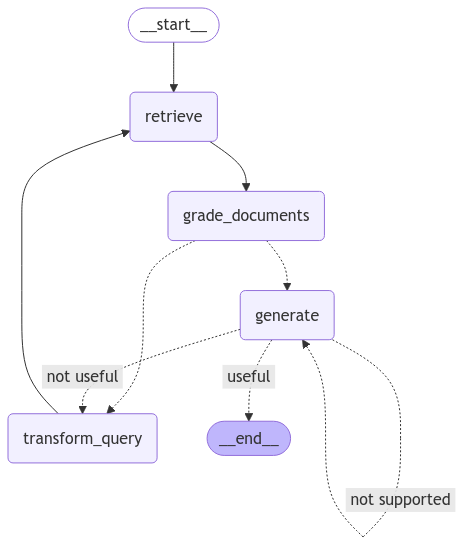

In [202]:
app

In [203]:
inputs = {"question": "What is the capital of Maharashtra ?"}
app.invoke(inputs)['generation']

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
binary_score='no'
---GRADE: DOCUMENT NOT RELEVANT---
binary_score='no'
---GRADE: DOCUMENT NOT RELEVANT---
binary_score='no'
---GRADE: DOCUMENT NOT RELEVANT---
binary_score='no'
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
binary_score='no'
---GRADE: DOCUMENT NOT RELEVANT---
binary_score='no'
---GRADE: DOCUMENT NOT RELEVANT---
binary_score='no'
---GRADE: DOCUMENT NOT RELEVANT---
binary_score='no'
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
binary_score='no'
---GRADE: DOCUMENT NOT RELEVANT---
binary_score='no'
---GRADE: DOCUMENT NOT RELEVANT---
binary_score='no'
---GRADE: DOCUMENT NOT

KeyboardInterrupt: 